# Load Libraries

In [48]:
import itertools

#Dataframe Libraries
import pandas as pd
import numpy as np

#Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Calculate confusion matrix
from sklearn.metrics import confusion_matrix

#Classes used for PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Isolation Forests
from sklearn.ensemble import IsolationForest

#Multiprocessing
from concurrent.futures import ProcessPoolExecutor, as_completed

# Specify Names of Columns

In [49]:
features = ['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate']

label = "label"
string_features = ['land', 'service','protocol_type','flag']
sumbolic_features = ["protocol_type", "service", "flag", "land", "logged_in", "is_host_login", "is_guest_login"]

numeric_features = [col for col in features if col not in sumbolic_features]
column_names = features + [label]

In [50]:
attack_types = {'dos': ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop'],
 'probe': ['ipsweep', 'nmap', 'portsweep', 'satan'],
 'r2l': ['ftp_write',
  'guess_passwd',
  'imap',
  'multihop',
  'phf',
  'spy',
  'warezclient',
  'warezmaster'],
 'u2r': ['buffer_overflow', 'loadmodule', 'perl', 'rootkit']}

# Misc Functions

In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Read Data

In [52]:
df_full = pd.read_csv("./kddcup.data.gz", header=None, names=column_names)
df_full["label"] = df_full.label.apply(lambda z: str(z).strip("."))

# Isolation Forest Classifier

![alt text](http://scikit-learn.org/stable/_images/sphx_glr_plot_isolation_forest_001.png "Isolation Forests")

You can think of [Isolation Forests](http://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest) as the unsupervised analogue of [Random Forests](https://en.wikipedia.org/wiki/Random_forest).

We'll use a simple Isolation Forests model to detect anomalies in the KDD-99 dataset just to convince us that detecting anomolies in this dataset is nontrivial.

Liu, Fei Tony, Ting, Kai Ming and Zhou, Zhi-Hua. “Isolation forest.” Data Mining, 2008. ICDM‘08. Eighth IEEE International Conference on.

### Train Data for Isolation Forest Classifier

In [53]:
ATTACK_FRACTION = .01
NORMAL_DATA_SIZE = 10**5

def get_train_data(df):

    X = df[df.label == 'normal'].sample(NORMAL_DATA_SIZE)
    Y = df[df.label != 'normal'].sample(int(NORMAL_DATA_SIZE*ATTACK_FRACTION))

    train_data = pd.concat([X,Y], ignore_index=True)
    return train_data

### Model for Isolation Forest Classifier

In [54]:
model = IsolationForest(n_jobs=8, contamination=ATTACK_FRACTION, max_features=8, n_estimators=1024)

#Define train data
train_data = get_train_data(df_full)

#Fit model
model.fit(train_data[numeric_features])

IsolationForest(bootstrap=False, contamination=0.01, max_features=8,
        max_samples='auto', n_estimators=1024, n_jobs=8, random_state=None,
        verbose=0)

### Compute confusion matrix for Isolation Forest Classifier

In [55]:
def get_small_confusion_matrix(model, X):

    results = model.predict(X[numeric_features])
    results = (results == -1)

    #Confusion matrix
    conf_matrix = confusion_matrix((X.label != 'normal').values, results)
    #print "Returning matrix: ", conf_matrix
    return conf_matrix

def get_confusion_matrix(X):
    
    batch_size = 10**5
    batches = np.array_split(X, len(X)/batch_size + 1)

    processes = []
    conf_matrix = np.array([[0,0], [0,0]])

    with ProcessPoolExecutor(5) as executor:
        
        for batch in batches:
            p = executor.submit(get_small_confusion_matrix, *(model, batch))
            processes.append(p)

        print "Total number of processes: ", len(processes)
        for i, future in enumerate(as_completed(processes)):

            print "Completed process %d of %d"%(i, len(processes))
            small_conf_matrix = future.result()
            conf_matrix = conf_matrix + small_conf_matrix
        
    return conf_matrix

In [56]:
conf_matrix = get_confusion_matrix(df_full[:10**6])

Total number of processes:  11
Completed process 0 of 11
Completed process 1 of 11
Completed process 2 of 11
Completed process 3 of 11
Completed process 4 of 11
Completed process 5 of 11
Completed process 6 of 11
Completed process 7 of 11
Completed process 8 of 11
Completed process 9 of 11
Completed process 10 of 11


Confusion matrix, without normalization
[[651412  92793]
 [313999 214523]]


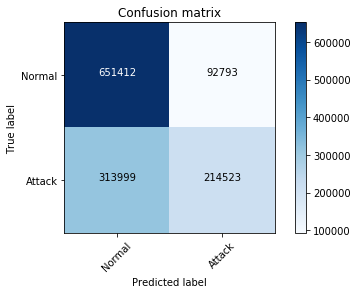

In [58]:
plot_confusion_matrix(conf_matrix, classes=['Normal', 'Attack'])

# The PCC Model

We're following the paper below to build an anomaly detection classifier.

A novel anomaly detection scheme based on principal component classifier In IEEE Foundations and New Directions of Data Mining Workshop, in conjunction with ICDM'03 (2003), pp. 171-179 by M-L Shyu, S-C Chen, K. Sarinnapakorn, L. Chang

### Overview

**Goal** To correctly label each connection as either "normal" or "attack".

**Example Data**

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/GaussianScatterPCA.svg/720px-GaussianScatterPCA.svg.png "Sample Data")

** Approach 1: ** Find the center, and take call the elements far from the center "anomolous". Far is defined by some user-defined threshold.

** Approach 2: ** Do the same thing as "Approach 1", but in a different coordinate system. Note, one such coordinate system comes from PCA.

**Recall** that *Principal Component Analysis* gives you a set of eigenvectors $e_1, \cdots, e_p$ (example above). Suppose that $\lambda_1, ... ,\lambda_p$ are the corresponding eigenvalues.

If $x$ is a datapoint, we can write it in terms of the basis of singular vectors:

$$ x = y_1 \cdot e_1  + y_2 \cdot e_2 + \cdots + y_p \cdot e_p  $$

Consider the distance function:

$$d(x) = \frac{y_1^2}{\lambda_1} + \frac{y_2^2}{\lambda_2} + \cdots + \frac{y_p^2}{\lambda_p}$$ 

### Define the model

In [59]:
pca = PCA()

### Fit PCA with 5K normal instances

In [60]:
#Make the training data
training_data = df_full[df_full.label == 'normal'].sample(5000)

standard_scalar = StandardScaler()
centered_training_data = standard_scalar.fit_transform(training_data[numeric_features])

#Fit PCA with the training data
pca.fit(centered_training_data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

### What goes into choosing a threshold for the distance

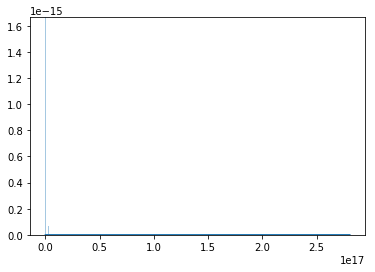

In [62]:
lambdas = pca.singular_values_
M = ((centered_training_data*centered_training_data)/lambdas)
distances = np.sum(M, axis=1)

_ = sns.distplot(distances, bins=500)

### Fit model parameters

#### Fit q

The parameter $q$ is defined so that the first $q$ components should explain $\sim50\%$ of the variance.

In [63]:
#The first q components should explain ~50% of the variance
q = 5

print "Explained variance by first q terms: ", sum(pca.explained_variance_ratio_[:q])

Explained variance by first q terms:  0.483628042286


#### Fit r

The parameter $r$ is defined so that all subsequent singular values are less than or equal to $.2$

In [37]:
singular_values = pca.singular_values_

assert list(singular_values) == sorted(singular_values, reverse=True), "Error! Array assumed sorted."
q_values = list(pca.singular_values_ < .2)

r = q_values.index(True)

In [38]:
print "q = %d, r = %d"%(q, r)

q = 5, r = 29


### Compute Distance Function: 

The authors define the sum of the major components:

$$major\_components(x) = \frac{y_1^2}{\lambda_1} + \frac{y_2^2}{\lambda_2} + \cdots + \frac{y_q^2}{\lambda_q}$$


$$minor\_components(x) = \frac{y_{r}^2}{\lambda_{r}} + \frac{y_{r+1}^2}{\lambda_{r+1}} + \cdots + \frac{y_q^2}{\lambda_q}$$

The function below computes both of these, as well as the $99^{\textrm{th}}$ percentiles of these quantities.

In [67]:
def get_components_and_quantiles(df, standard_scalar = standard_scalar):
    
    data = standard_scalar.transform(df[numeric_features])
    transformed_data = pca.transform(data)
    y = transformed_data
    
    lambdas = pca.singular_values_
    M = ((y*y)/lambdas)
    
    major_components = M[:,range(q)]
    minor_components = M[:,range(r, len(numeric_features))]
    
    major_components = np.sum(major_components, axis=1)
    minor_components = np.sum(minor_components, axis=1)
     
    components = pd.DataFrame({'major_components': major_components, 
                               'minor_components': minor_components})
    
    print components.quantile(0.99)
    
    c1 = components.quantile(0.99)['major_components']
    c2 = components.quantile(0.99)['minor_components']
    
    return major_components, minor_components, c1, c2

### Set the parameters $c_1$ and $c_2$ from training data

In [68]:
_, _ , c1, c2 = get_components_and_quantiles(training_data)

major_components    1.148393e+00
minor_components    3.140320e-15
Name: 0.99, dtype: float64


### Calculate the major and minor components for full data

In [69]:
major_components, minor_components, _, _  = get_components_and_quantiles(df_full)

major_components    5.660635e+01
minor_components    2.878642e-13
Name: 0.99, dtype: float64


### Define the classifier

In [70]:
def classifier(major_components, minor_components):
    
    major = major_components > c1
    minor = minor_components > c2
    
    return np.logical_or(major,minor)

### Predict on the full dataset

In [71]:
results = classifier(major_components=major_components, minor_components=minor_components)

### Plot the confusion matrix

Confusion matrix, without normalization
[[ 957968   14813]
 [  25684 3899966]]


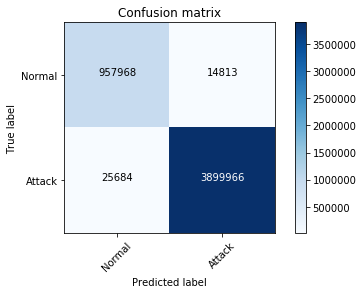

In [72]:
conf_matrix = confusion_matrix((df_full['label'] != 'normal').values, results)
tn, fp, fn, tp = conf_matrix.ravel()

plot_confusion_matrix(conf_matrix, classes=['Normal', 'Attack'])

### Basic Results

In [73]:
print "False positive rate: ", fp/float(fp + tn)
print "Precision TP/(TP + FP): ", tp/float(tp + fp)
print "Recall: TP/(TP + FN)", tp/float(tp + fn)

False positive rate:  0.015227476688
Precision TP/(TP + FP):  0.996216133784
Recall: TP/(TP + FN) 0.993457389222


# Further Directions

## Spark 

![alt text](https://covers.oreillystatic.com/images/0636920056591/lrg.jpg "Spark")

Chapter 5 builds a classifier for the KDD 99 dataset in Spark.